In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from matplotlib import font_manager, rc
import json

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['axes.unicode_minus'] = False

# 한글 설정
f_path = "/Users/seyoung/Library/Fonts/AppleGothic.ttf"
font_name = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family=font_name)

data_url = '../datas/jeju_hotel_pivot.csv'
hotel_data = pd.read_csv(data_url, sep=',')

# api key 호출
def get_secretKeys():
    file = open("../keys/secret_keys.txt", "rt")
    split_keys = []
    line_count = 0
    
    load_datas = file.readlines()
    
    file.close()
    
    for i in range(len(load_datas)):
        split_keys.append(load_datas[i].split('=')[1].replace('"', ""))
    
    return split_keys

# api 요청 url 생성
def get_search_url(addr):
    api_keys = get_secretKeys()
    
    base = 'https://dapi.kakao.com/v2/local/search/address.json'
    header_phrase = 'KakaoAK'
    api_key = api_keys[1]
    
    headers = {'Authorization': header_phrase + api_key[1:]}
    req_param = '?query=' + str(addr)
    url = base + req_param
    
    return url, headers

# api 요청 응답
def get_result(url, headers):
    req = requests.get(url, headers=headers)
    res = json.loads(req.text)
    
    return res

# 응답 데이터 파싱
def json_parsing(res):
    
    res_dict = res['documents']
    x = res_dict[0]['x']
    y = res_dict[0]['y']
    
    return x, y

# 호텔 주소 데이터 위도 경도 변환 수행
addr_col = hotel_data.iloc()[:, -1:]
addr_list = [addr_col.loc()[i].tolist() for i in range(len(hotel_data))]

lat, lng = [], []

for i in range(len(addr_list)):
    target = addr_list[i]
    url, headers = get_search_url(target)
    res = get_result(url, headers)
    
    try:
        x, y = json_parsing(res)
        lat.append(x)
        lng.append(y)
        
    except:
        lat.append(0)
        lng.append(0)


lat = pd.DataFrame(columns=['x'], data=lat)
lng = pd.DataFrame(columns=['y'], data=lng)


# drop 0
drop_lat_list = lat.index[lat['x'] == 0.0].tolist()
drop_lat_zero = lat.drop(index=drop_lat_list)
drop_lat_zero.reset_index(drop=True, inplace=True)

drop_lng_list = lng.index[lng['y'] == 0.0].tolist()
drop_lng_zero = lng.drop(index=drop_lng_list)
drop_lng_zero.reset_index(drop=True, inplace=True)

lat = [drop_lat_zero.loc()[i][0] for i in range(len(drop_lat_zero))]
lng = [drop_lng_zero.loc()[i][0] for i in range(len(drop_lng_zero))]

rd_lat = [round(float(lat[i]), 6) for i in range(len(lat))]
rd_lng = [round(float(lng[i]), 6) for i in range(len(lng))]

type(rd_lat), type(rd_lng)

lat_df = pd.DataFrame(columns=['x'], data=rd_lat)
lng_df = pd.DataFrame(columns=['y'], data=rd_lng)

hotel_data = pd.concat([hotel_data, lat_df, lng_df], axis=1)

# 1,2,3 성급을 제외한 실제 4,5 성급 호텔
options = [4.0, 5.0]

df = pd.DataFrame(hotel_data, columns=hotel_data.columns)
df = hotel_data[hotel_data['avg_star'].isin(options)]
df.dropna()
df = df.iloc[:, -2:]
df['name'] = 'a'
df

,x,y,name
1,126.604286,33.241092,a
13,126.897845,33.402648,a
37,126.522387,33.244210,a
39,126.709468,33.472091,a
40,126.562333,33.244088,a
...,...,...,...
507,126.565765,33.246774,a
511,126.932375,33.463672,a
515,NaN,NaN,a
517,NaN,NaN,a


In [29]:
original = pd.read_csv("../datas/jeju_financial_life_data.csv")
data = original.drop(['job_none','job_other'],axis=1)
job_df = data[['job_majorc','job_smallc','job_public','job_profession','job_self']].copy()

# 무직, 기타 컬럼 drop 후 비중 재반영
job_majorc = []
job_smallc = []
job_public = []
job_profession = []
job_self = []

for a in range(0, len(original)):
    row_sum = 0
    for i in range(0,5):
        row_sum += job_df.loc[a][i]
        
    if row_sum == 0:
        job_majorc.append(0.0)
        job_smallc.append(0.0)
        job_public.append(0.0)
        job_profession.append(0.0)
        job_self.append(0.0)
    else:
        job_majorc.append(job_df.loc[a][0]/row_sum)
        job_smallc.append(job_df.loc[a][1]/row_sum)
        job_public.append(job_df.loc[a][2]/row_sum)
        job_profession.append(job_df.loc[a][3]/row_sum)
        job_self.append(job_df.loc[a][4]/row_sum)
        
job_df['job_majorc']=job_majorc
job_df['job_smallc']=job_smallc
job_df['job_public']=job_public
job_df['job_profession']=job_profession
job_df['job_self']=job_self

# job_points 컬럼 추가: 직업군별 가중치
# job_points = [100, 68, 92, 100, 60]
job_points = [100, 68, 92, 100, 60]
sum_list = []
for a in range(0, len(original)):
    row_sum = 0
    for i in range(0,5):
        row_sum += job_df.loc[a][i]*job_points[i]
    sum_list.append(round(row_sum,2))

data['job_points'] = sum_list

# 무직과 기타만 있던 행 삭제
drop_zero = data[data['job_points']==0].index
data = data.drop(drop_zero)

# job points를 기준으로 총 5개의 level로 분리
# 상위 1% (a등급), 4분위수 기준으로 나머지 4개 등급 분리(b~e등급)
job_level = []
level = ['e','d', 'c', 'b', 'a']
q = [0.25, 0.5, 0.75, 0.99, 1]

for i in range(0, len(original)):
    for index in range(0, 5):
        try:
            if data['job_points'].loc[i] <= data['job_points'].quantile(q[index]):
                job_level.append(level[index])
                break
        except KeyError:
            pass
        
# data 데이터 프레임에 job level 컬럼 추가
data['job_level'] = job_level

# a 등급만의 데이터 가져오기
jeju_a_lv = data[data['job_level']=='a']

# a 등급만의 데이터에서 좌표값 컬럼만 남기기
jeju_a_lv = jeju_a_lv[['x_axis','y_axis']]
jeju_a_lv['name'] = 'b'
jeju_a_lv.reset_index(inplace=True, drop=True)

jeju_a_lv = jeju_a_lv[['x_axis','y_axis']]
jeju_a_lv['name'] = 'b'
jeju_a_lv.reset_index(inplace=True, drop=True)
jeju_a_lv.rename(columns={'x_axis':'x', 'y_axis':'y'}, inplace=True)
jeju_a_lv

,x,y,name
0,126.554738,33.501845,b
1,126.546748,33.508162,b
2,126.521242,33.505113,b
3,126.546112,33.514340,b
4,126.546112,33.514340,b
...,...,...,...
98,126.545353,33.502651,b
99,126.712843,33.551262,b
100,126.491201,33.254887,b
101,126.491201,33.254887,b


In [34]:
merge_df = pd.concat([df, jeju_a_lv], axis=0)
merge_df.reset_index(inplace=True, drop=True)
merge_df

,x,y,name
0,126.604286,33.241092,a
1,126.897845,33.402648,a
2,126.522387,33.244210,a
3,126.709468,33.472091,a
4,126.562333,33.244088,a
...,...,...,...
186,126.545353,33.502651,b
187,126.712843,33.551262,b
188,126.491201,33.254887,b
189,126.491201,33.254887,b


In [40]:
# api key 호출
def get_secretKeys():
    
    file = open("../keys/secret_keys.txt", "rt")
    split_keys = []
    line_count = 0
    
    load_datas = file.readlines()
    
    file.close()
    
    for i in range(len(load_datas)):
        split_keys.append(load_datas[i].split('=')[1].replace('"', ""))
    
    return split_keys


# api 요청 url 생성
def get_search_url(req_x, req_y):
    
    api_list = get_secretKeys()
    
    base = "https://dapi.kakao.com/v2/local/geo/coord2regioncode.json"     
    header_phrase = "KakaoAK"
    api_key = api_list[1] 
    
    
    headers = {"Authorization": header_phrase + api_key[1:]} # api_key[1:] = 공백 제거
    
    req_lat = "?x=" + str(req_x)
    req_lng = "&y=" + str(req_y)
    
    url = base + req_lat + req_lng
    req_set = (url, headers)
    
    return req_set


def get_result(url, header):
    
    req = requests.get(url, headers=header)
    res = json.loads(req.text)
     
    return res


# 변환된 위도,경도를 주소로 요청
def reverse_geocoding(req_x, req_y):

    req_set = get_search_url(req_x, req_y)
    res_api = get_result(req_set[0], req_set[1])
    
    return res_api


# reverse geocoding start
proj_x = [merge_df['x'].tolist()]
proj_y = [merge_df['y'].tolist()]

res_json = []

for i in range(len(proj_x[0])):
    try:
        raw_res_json = reverse_geocoding(proj_x[0][i], proj_y[0][i])
        res_json.append(raw_res_json['documents'][0]['region_3depth_name'])
    except:
        res_json.append('')

        
merge_df['Dong'] = res_json
merge_df.tail(3)

,x,y,name,Dong
188,126.491201,33.254887,b,강정동
189,126.491201,33.254887,b,강정동
190,126.533893,33.501538,b,이도이동


In [57]:
# a+b 상위 동
dong_count = merge_df.groupby(['Dong']).count()
dong_count.iloc[:,-1:].sort_values(by='name', ascending=False)

,name
Dong,
성산읍,16
남원읍,14
애월읍,14
연동,11
한림읍,10
안덕면,8
이도이동,8
조천읍,8
구좌읍,7


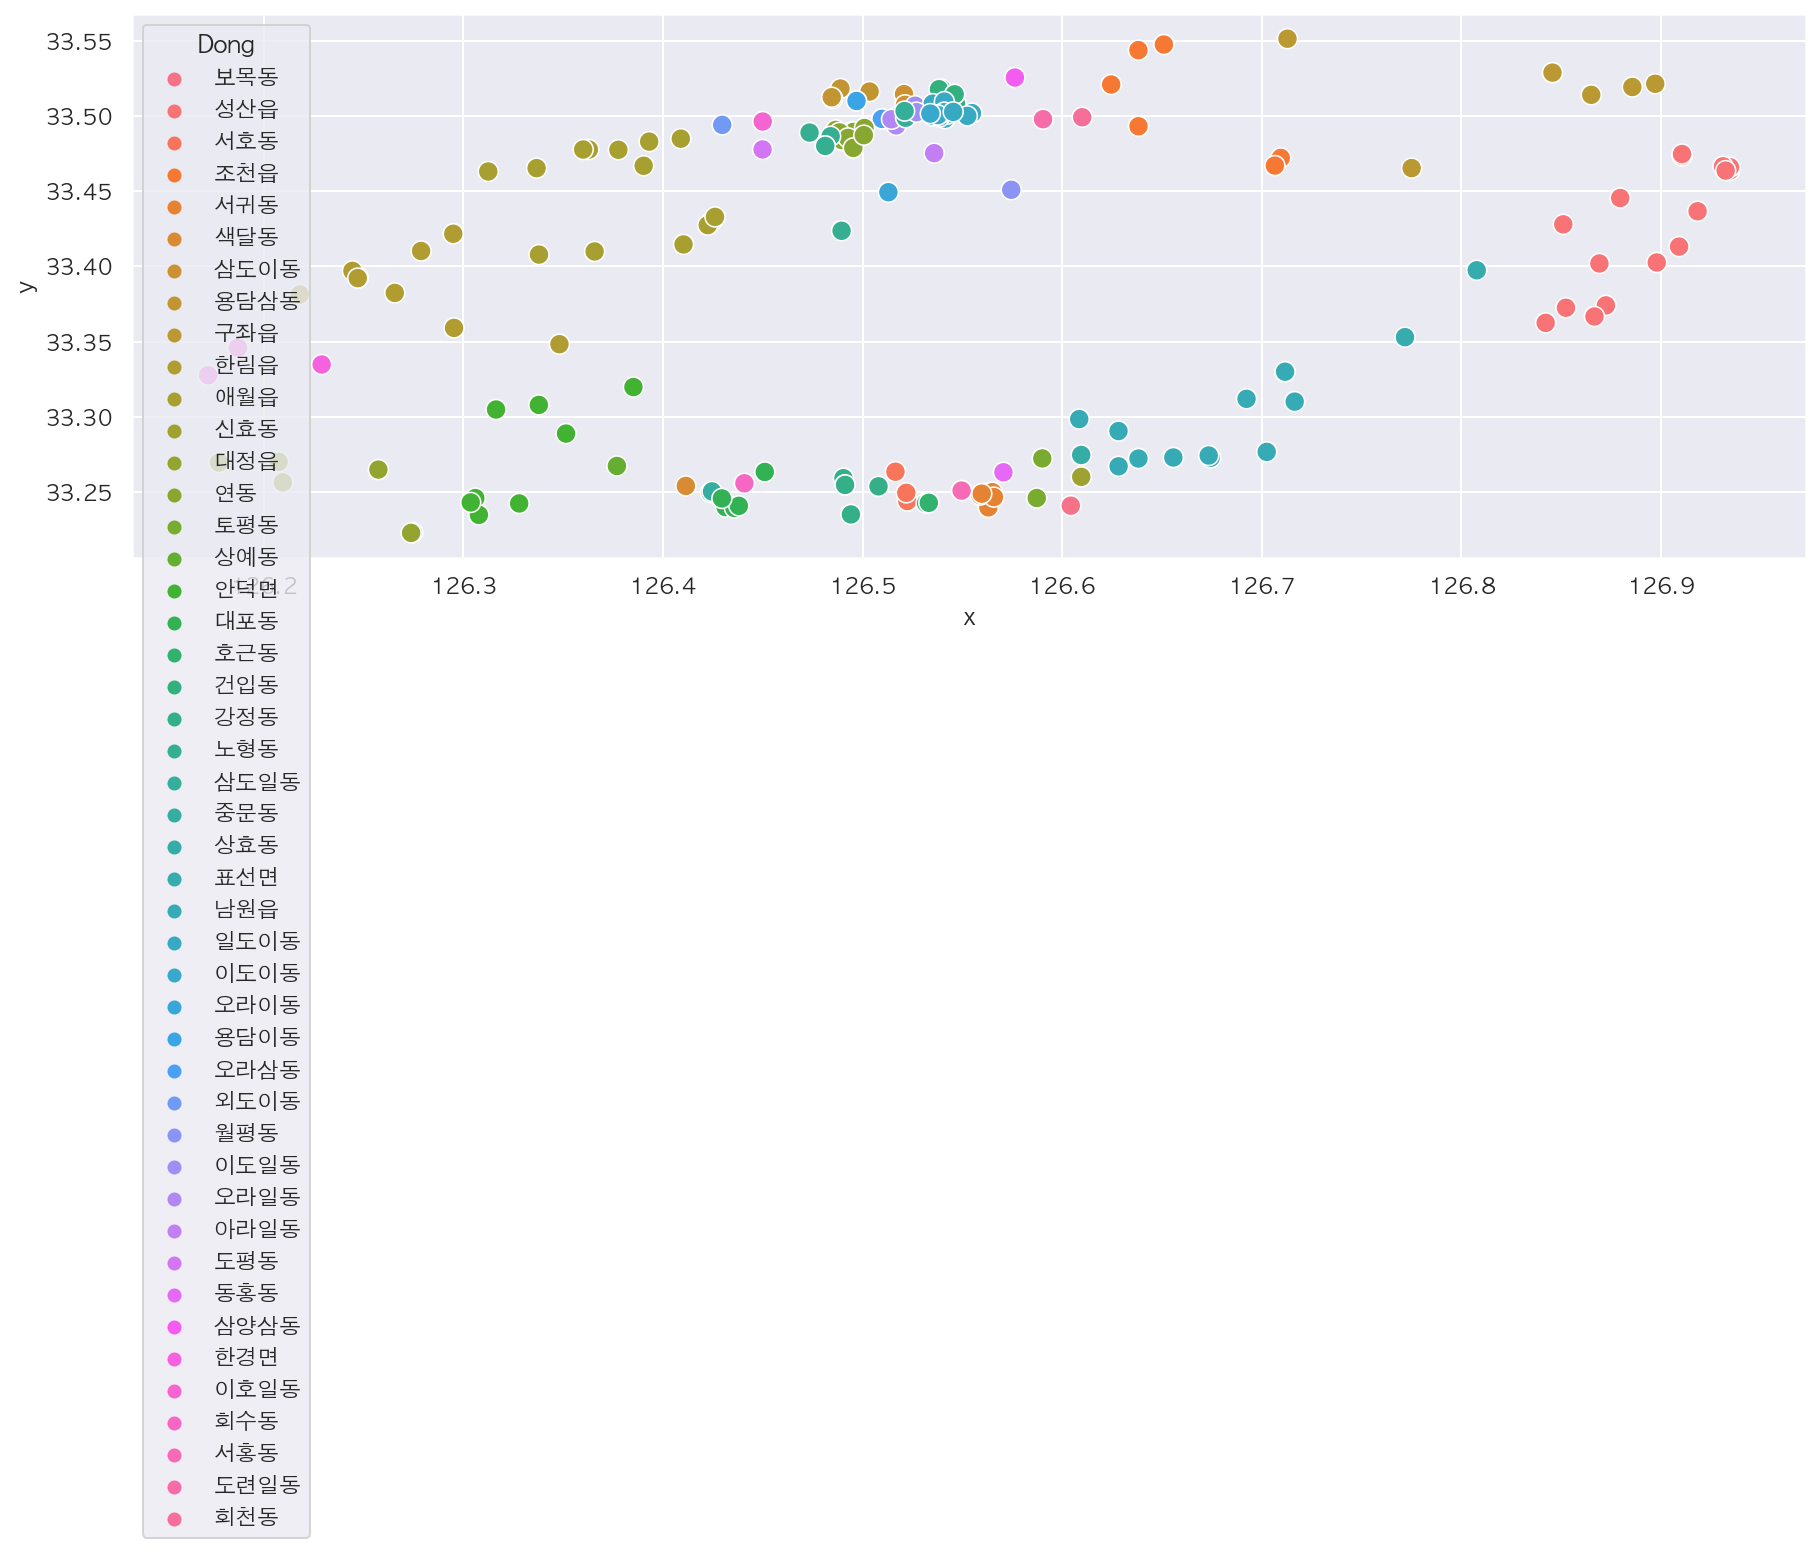

In [58]:
# 제주도민과 관광객 호텔 소비를 합친 scatterplot
sns.set(rc={'figure.figsize':(15,5),'axes.unicode_minus':False}, font='AppleGothic')
with sns.color_palette('husl', 3):
    sns.scatterplot('x', 'y', hue='Dong', data=merge_df, s=100);